In [1]:
import tensorflow.compat.v2 as tf
import numpy as np
import tensorflow_addons as tfa
import functools

/home/pedri0/anaconda3/envs/SIM/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201129). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
#from data_util.py
def random_brightness(image, max_delta, impl='simclrv2'):
    #A multiplicative vs additive change of brightness
    if impl == 'simclrv2':
        factor = tf.random.uniform([], tf.maximum(1.0-max_delta, 0), 1.0+max_delta)
        image = image * factor
    elif impl == 'simclrv1':
        image = tf.image.random_brightness(image, max_delta=max_delta)
    else:
        raise ValueError('Unknown impl {} for random brightness.'.format(impl))
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0, impl='simclrv2'):
    #Distorts the color of the image (jittering order is random)
    with tf.name_scope('distort_color'):
        def apply_transform(i,x):
            #apply the i-th transformation
            def brightness_foo():
                if brightness == 0:
                    return x
                else:
                    return random_brightness(x, max_delta=brightness, impl=impl)
            
            def contrast_foo():
                if contrast == 0:
                    return x
                else:
                    return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
            
            def saturation_foo():
                if saturation == 0:
                    return x
                else:
                    return tf.image.random_saturation(x, lower=1-saturation, upper=1+saturation)

            def hue_foo():
                if hue == 0:
                    return x
                else:
                    return tf.image.random_hue(x, max_delta = hue)
            
            x = tf.cond(tf.less(i, 2),
                lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
            return x

        perm = tf.random.shuffle(tf.range(4))
        for i in range(4):
            image = apply_transform(perm[i], image)
            #image = tf.clip_by_value(image, 0., 1.)
        return image


def color_jitter(image, strength, impl='simclrv2'):
    #Distorts the color of the image
    #random_order: A bool, specifying whether to randomize the jittering order.
    #impl: 'simclrv1' or 'simclrv2'.  Whether to use simclrv1 or simclrv2's version of random brightness.
    brightness = 0.8 * strength
    contrast = 0.8 * strength
    saturation = 0.8 * strength
    hue = 0.2 * strength
    #removed color_jitter_nonrand
    return color_jitter_rand(image, brightness, contrast, saturation, hue, impl=impl)


def to_grayscale(image, keep_channels=True):
    image = tf.image.rgb_to_grayscale(image)
    if keep_channels:
        image = tf.tile(image, [1, 1, 3])
    return image


def random_apply(func, p, x):
    #Randomly apply function func to x with probability p.
    return tf.cond(tf.less(
        tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
        tf.cast(p, tf.float32)), lambda: func(x), lambda: x)


def random_color_jitter(image, p=1.0, impl='simclrv2'):

    def _transform(image):
        color_jitter_t = functools.partial(color_jitter, strength=1.0, impl=impl)
        image = random_apply(color_jitter_t, p=0.8, x=image)
        return random_apply(to_grayscale, p=0.2, x=image)
    
    return random_apply(_transform, p=p, x = image)

In [3]:
def Squeeze(tensor):
    return tf.squeeze(tensor)
def Tensor(image):
    image = tf.keras.preprocessing.image.img_to_array(image)
    return tf.convert_to_tensor(image)
def Expand(tensor):
    return tf.expand_dims(tensor, axis=0)
def Image(tensor):
    tensor = Squeeze(tensor)
    tensor = tensor.numpy()
    return tf.keras.preprocessing.image.array_to_img(tensor)

image = tf.keras.preprocessing.image.load_img('J000047.88+141639.1.jpg')
image = tf.keras.preprocessing.image.img_to_array(image)
image = Tensor(image)
image = Expand(image)

In [4]:
i = random_color_jitter(image)

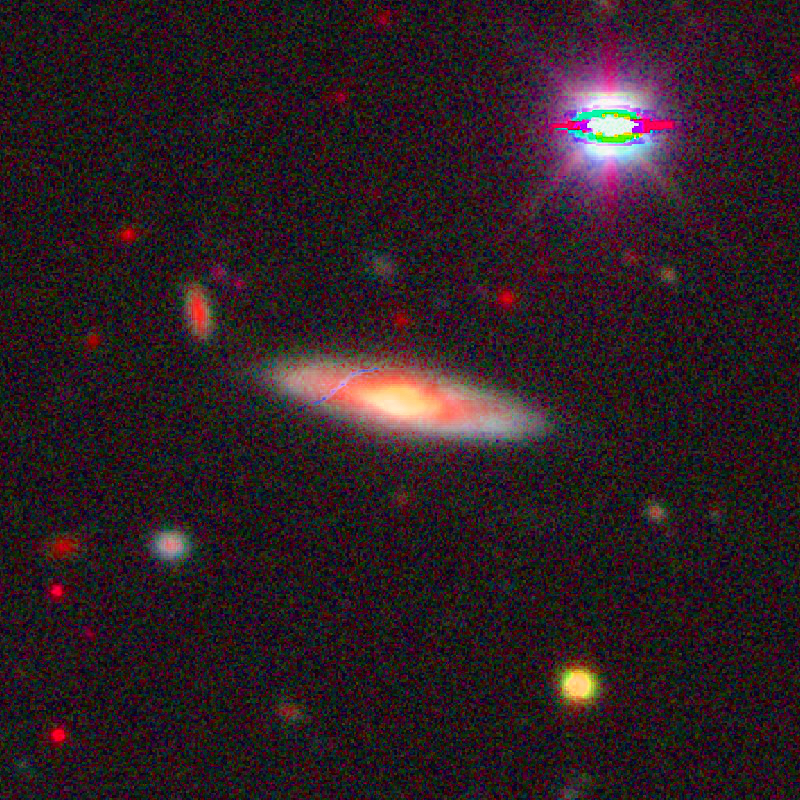

In [5]:
i = Image(i)
i

In [7]:
def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
    #Blurs the given image with separable convolution
    #kernel_size: Integer Tensor for the size of the blur kernel. This is should
    #  be an odd number. If it is an even number, the actual kernel size will be size + 1.
    #sigma: Sigma value for gaussian operator.
    #padding: Padding to use for the convolution. Typically 'SAME' or 'VALID'.
    radius = tf.cast(kernel_size/2, dtype=tf.int32)
    kernel_size = radius * 2 + 1
    x = tf.cast(tf.range(-radius, radius + 1), dtype=tf.float32)
    blur_filter = tf.exp(-tf.pow(x, 2.0) / (2.0*tf.pow(tf.cast(sigma, dtype=tf.float32), 2.0)))
    blur_filter /= tf.reduce_sum(blur_filter)
    #one vertical and one horizontal filter
    blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
    blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
    num_channels =  tf.shape(image)[-1]
    blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
    expand_batch_dim = image.shape.ndims == 3
    if expand_batch_dim:
       #Tensorflow requires batched input to convolutions, which we can fake with an extra dimension
       image = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(image, blur_h, strides=[1,1,1,1], padding=padding)
    blurred = tf.nn.depthwise_conv2d(blurred, blur_v, strides=[1,1,1,1], padding=padding)
    if expand_batch_dim:
        blurred = tf.squeeze(blurred, axis=0)
    return blurred

In [23]:
def sobel(image, magnitude=False, denoise=True):
    if denoise:
        image = gaussian_blur(image, image.shape[1]//10, 3)
    sobel_mag = tf.image.sobel_edges(image)
    if magnitude == True:
        sobel_mag = tf.math.square(sobel_mag)
        sobel_mag = tf.math.sqrt(sobel_mag)
        sobel_mag = sobel_mag[:,:,:,:,0] + sobel_mag[:,:,:,:,1]
        return sobel_mag
    else:
        prob_x = tf.random.uniform([1], minval=0, maxval=1, dtype=tf.dtypes.float32)
        if prob_x >= 0.5:
            return sobel_mag[:,:,:,:,0]
        else:
            return sobel_mag[:,:,:,:,1]

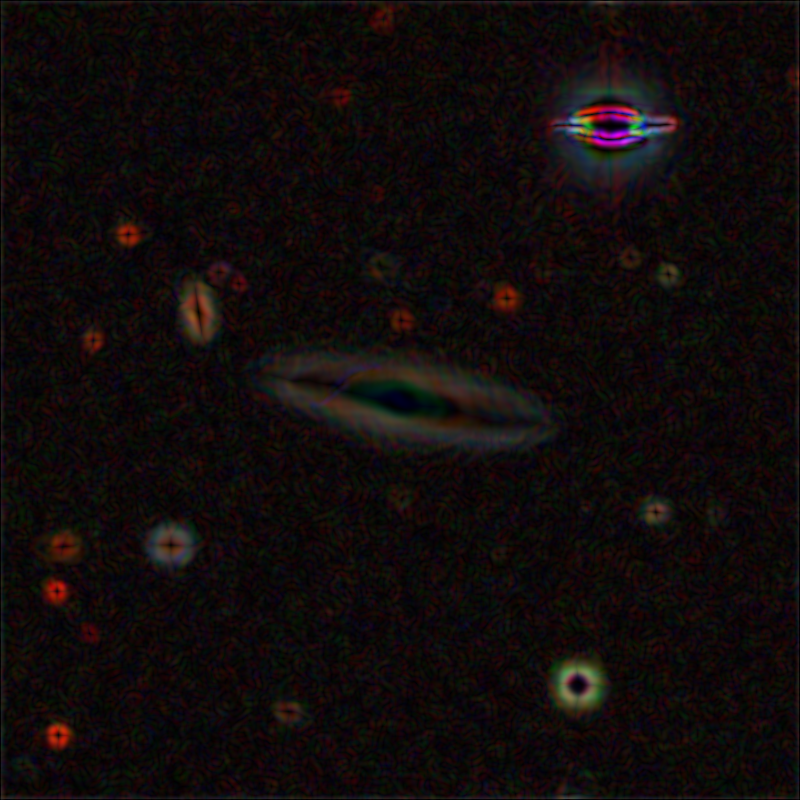

In [24]:
sob = sobel(image,magnitude=True, denoise=True)
sob = Image(sob)
sob

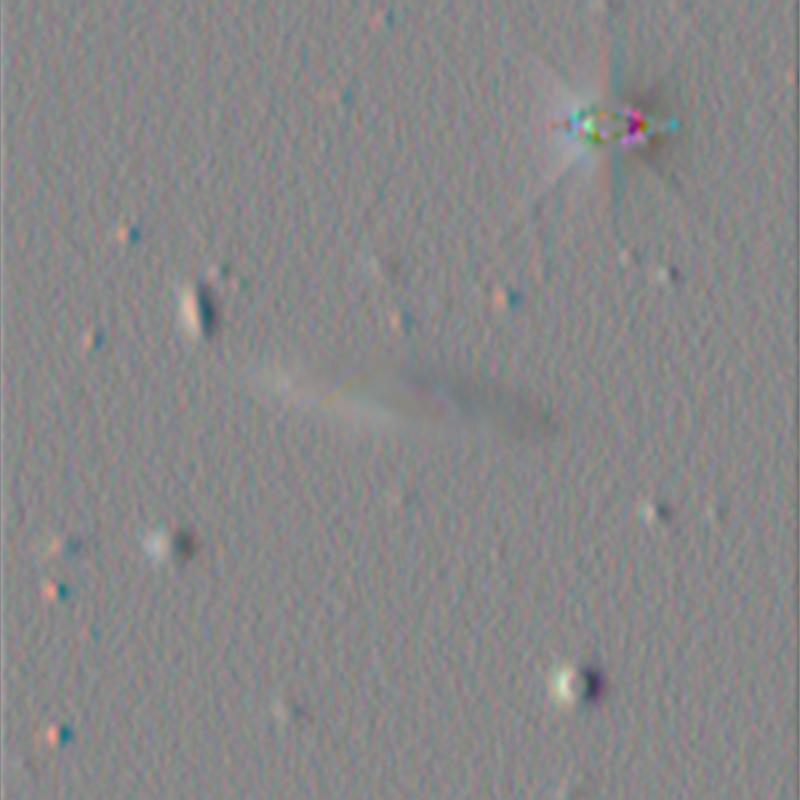

In [25]:
sobx = sobel(image, magnitude=False, denoise=True)
sobx = Image(sobx)
sobx

In [11]:
image.shape[1]//10

80